## Customized loss
This notebook provides customized loss example using the Silver nanoparticle (AgNPs) dataset.

###  Silver nanoparticle process data

In this dataset, the input are processing conditions for AgNPs which are nicely arranged in numerical format. The output is an absorption spectra of each AgNP. The objective of this experiment is to optimize the processing conditions of AgNPs to achieve targeted absorption spectra. Since the output and target are all spectra, we can still use MAE, MSE or PMAE. But it will not work nicely. In this notebook, we will showcase a few customized losses used in the two studies [Ref1](https://www.nature.com/articles/s41467-020-16501-4) and [Ref2](https://chemrxiv.org/articles/preprint/Two-Step_Machine_Learning_Enables_Optimized_Nanoparticle_Synthesis/12673742/1?file=23973425)

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [105]:
raw_input = pd.read_excel('./data/AgNPs.xlsx','Sheet1')
raw_spectra = pd.read_excel('./data/AgNPs.xlsx','Sheet2',index_col=0)
raw_target = pd.read_excel('./data/AgNPs.xlsx','Target')


Let us first plot our target spectrum

Text(0.5, 1.0, 'Target')

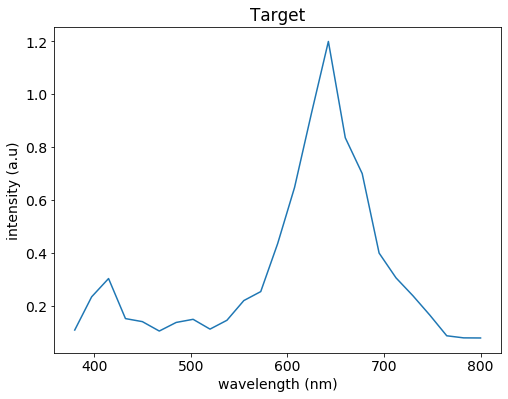

In [106]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams ['font.size'] =14
plt.plot(raw_target.iloc[:,0],raw_target.iloc[:,2])
plt.xlabel('wavelength (nm)')
plt.ylabel ('intensity (a.u)')
plt.title('Target')

Then we plot the measured spectra for AgNPs

Text(0.5, 1.0, 'Output')

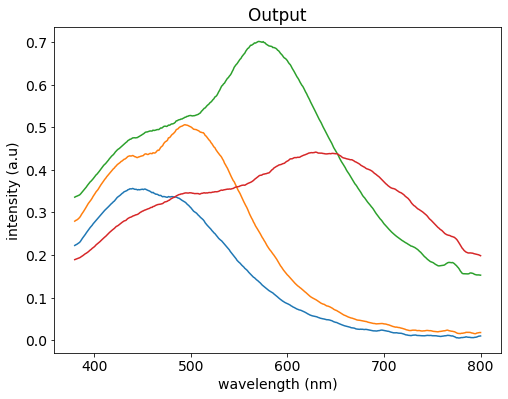

In [110]:
plt.plot(raw_spectra.iloc[:,[1,100,500,1000]])
plt.xlabel('wavelength (nm)')
plt.ylabel ('intensity (a.u)')
plt.title ('Output')

The target spectrum and the measured spectrum have different resolutions. We can use interpolation to unify the range

In [111]:
import scipy.interpolate as interp

wave = np.arange(380,801,1)

f = interp.interp1d(raw_target.iloc[:,0],raw_target.iloc[:,2],kind='slinear')

target_spec = f(wave)

scaler = MinMaxScaler()

target_spec_norm = scaler.fit_transform(target_spec.reshape(-1,1))

###  Customizing the loss 

let us first take a look at what will happen if we directly use MSE

In [133]:
def mse(target, prediction): 

    return np.sum(((target - prediction)**2),axis=0)

In [134]:
mse_loss  = mse (raw_spectra.values, target_spec_norm)

Text(0.5, 1.0, 'MSE')

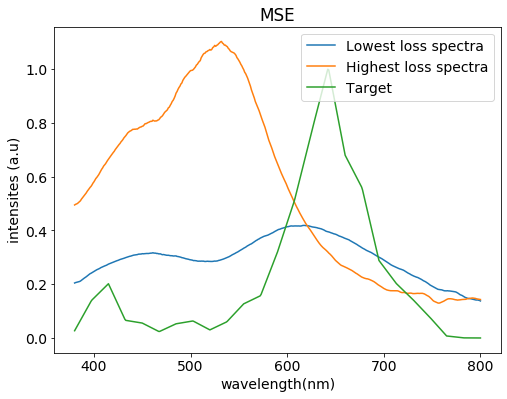

In [142]:
a = int(np.argmin(mse_loss))
b= int(np.argmax(mse_loss))
plt.plot(raw_spectra.iloc[:,a], label ='Lowest loss spectra')
plt.plot(raw_spectra.iloc[:,b],label ='Highest loss spectra')
plt.plot(wave,target_spec_norm, label ='Target')
plt.xlabel ('wavelength(nm)')
plt.ylabel ('intensites (a.u)')
plt.legend()
plt.title('MSE')

Now, let us use some customized losses that leverages on certain spectrum's attributes. Ref1 looks at the peak wavelength and how it is different from the target. We can construct a customized function:

In [135]:
def peak_loss_function(spectra, target_spec_norm):
    data = spectra.values
    
    loss = []
   
    
    for i in range(data.shape[1]):
        idx_m = np.argmax(data[:,i])
        idx_t = np.argmax(target_spec_norm)
        peak_difference = np.abs(idx_m-idx_t) #+ 1000*np.max(data[:,i])
      
        loss.append(peak_difference)
    return np.array(loss)
      
    

Ref2 looks at the uses the cosine similarity between the target and measured spectrum. We can construct a customized function:

In [136]:
from sklearn.metrics.pairwise import cosine_similarity
#scaler the target spectra from 0 to 1
scaler = MinMaxScaler()

def step_int(x):
    if x>1.2:
        y = 0
    elif 0.7<=x<=1.2:
        y = 1
    elif 0<x<0.7:
        y = x/0.7 
    return y



def spectra_loss_function (spectra, target_spec_norm):
    data = spectra.values
    
    loss = []
   
    
    for i in range(data.shape[1]):
        step_coeff = step_int(max(data[:,i]))
        data_col = scaler.fit_transform(data[:,i].reshape(-1,1))
        cos_loss = cosine_similarity(target_spec_norm.T,data_col.T)
        
        single_loss = cos_loss*step_coeff
        loss.append(single_loss[0])
    loss= 1- np.array(loss)       
 
    return loss



In [148]:
loss_cos  = spectra_loss_function (raw_spectra.iloc[:,:2000], target_spec_norm)

loss_peak  = peak_loss_function (raw_spectra.iloc[:,:2000], target_spec_norm)

We can plot the spectra with lowest and highest losses

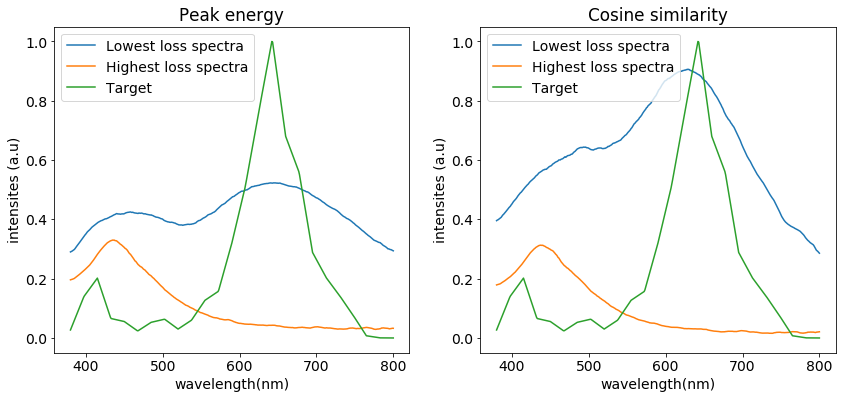

In [149]:
fig,ax = plt.subplots(1,2,figsize=(14,6))
loss = [loss_peak , loss_cos]
title = ['Peak energy','Cosine similarity']
for i in range(len(loss)):
    a = np.argmin(loss[i])
    b= np.argmax(loss[i])
    ax[i].plot(raw_spectra.iloc[:,a], label ='Lowest loss spectra')
    ax[i].plot(raw_spectra.iloc[:,b],label ='Highest loss spectra')
    ax[i].plot(wave,target_spec_norm, label ='Target')
    ax[i].set_xlabel ('wavelength(nm)')
    ax[i].set_ylabel ('intensites (a.u)')
    ax[i].legend()
    ax[i].set_title(title[i])

